# Лабораторная работа №3
# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

Выполнил: **Пакало А. С., РТ5-61Б**

## Задание
Выберите набор данных (датасет) для решения задачи классификации или
регрессии.
- С использованием метода train_test_split разделите выборку на обучающую и
  тестовую.
- Обучите модель ближайших соседей для произвольно заданного гиперпараметра
K.
  Оцените качество модели с помощью подходящих для задачи метрик.
- Произведите подбор гиперпараметра K с использованием GridSearchCV и/или
  RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели.
  Желательно использование нескольких стратегий кросс-валидации.
- Сравните метрики качества исходной и оптимальной моделей.

## Текстовое описание набора данных
Для обучения по методу K ближайших соседей (KNN) был выбран датасет с
классификацией типа звёзд c ресурса kaggle (Star Type Classification / NASA).
 
В данном наборе данных присутствуют следующие столбцы:
* Temperature — температура звезды в Кельвинах;
* L (Luminosity) — светимость звезды в солнечных светимостях;
* R (Radius) — радиус звезды в радиусах солнца;
* A_M (Absolute Magnitude) — абсолютная звёздная величина;
* Color — цвет света звезды;
* Spectral_Class — спектральный класс звезды;
* Type — тип звезды. Является целевым признаком и уже закодирован:
  - Красный карлик — 0;
  - Коричневый карлик — 1;
  - Белый карлик — 2;
  - Звезда из главной последовательности — 3;
  - Супергигант — 4;
  - Гипергигант — 5.

Так как данных очень много, перед тем как приступить к анализу, проведем обзор данных и, возможно, потребуется их предобработка, чтобы датасет стал более удобным и пригодным к проведению исследования.

Таким образом исследование пройдет в 7 этапов:
- загрузка данных,
- проведение разведочного анализа данных и предобработка данных,
- разделение на обучающую и тестовую выборку,
- выбор метрики,
- обучение модели,
- подбор гиперпараметра,
- сравнение значений метрики.

## Импортирование необходимых библиотек, подготовка окружения

In [208]:
# Основные библиотеки.
from IPython.core.display import display_markdown
import numpy as np
import pandas as pd

# Визуализция.
import matplotlib.pyplot as plt
import seaborn as sns

# Для матрицы взаимодействий.
from scipy import sparse
# Для разбития выборки.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from DataFrameOneHotEncoder import DataFrameOneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Отрисовка статуса выполнения.
from tqdm.notebook import tqdm

# Типизация.
from typing import List

# Вывод данных.
from IPython.display import display


# Конфигурация визуализации.
%matplotlib inline
sns.set(style='ticks')

## Загрузка данных
### Считываем данные из .csv
Загрузим файлы датасета в помощью библиотеки Pandas.

Не смотря на то, что файлы имеют расширение txt они представляют собой данные
в формате [CSV](https://ru.wikipedia.org/wiki/CSV). Часто в файлах такого
формата в качестве разделителей используются символы ",", ";" или табуляция.
Поэтому вызывая метод read_csv всегда стоит явно указывать разделитель данных
с помощью параметра sep. Чтобы узнать какой разделитель используется в файле
его рекомендуется предварительно посмотреть в любом текстовом редакторе.

In [209]:
stars = pd.read_csv('data/Stars.csv')

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и предобработка данных.

Размеры датасета: (строки, колонки).

In [210]:
stars.shape

(240, 7)

Общий вид данных таблицы:

In [211]:
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Список колонок:

In [212]:
stars.columns

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

Список колонок с типами данных:

In [213]:
stars.dtypes

Temperature         int64
L                 float64
R                 float64
A_M               float64
Color              object
Spectral_Class     object
Type                int64
dtype: object

Как видно, все данные приведены к адекватному типу данных.

## Предобработка данных

In [214]:
# Извлекаем целевой признак.
TARGET_COL_NAMES = ['Type']
star_types = stars[TARGET_COL_NAMES]

star_features = stars.drop(columns=TARGET_COL_NAMES)
display(star_types, star_features)

,Type
0,0
1,0
2,0
3,0
4,0
...,...
235,5
236,5
237,5
238,5


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


In [215]:
# Перед использованием модели закодируем категориальные признаки с помощью
# one-hot encoding, где каждое уникальное значение признака становится новым
# признаком. Это позволяет избежать фиктивного отношения порядка.

In [216]:
categorical_pipeline = Pipeline([
    ( 'one-hot', DataFrameOneHotEncoder(handle_unknown='ignore') )
])
CATEGORICAL_COL_NAMES = ['Color', 'Spectral_Class']
# Returns tuple: (2d-array with columns?, shape).
caterogical_star_features = categorical_pipeline.fit_transform(stars[CATEGORICAL_COL_NAMES]),
caterogical_star_features = pd.DataFrame(caterogical_star_features[0])

Нам также потребуется масштабировать данные для адекватной работы модели.

In [217]:
numerical_pipeline = Pipeline([
    ( 'scaler', StandardScaler() )
])


numerical_star_features = star_features.drop(columns=CATEGORICAL_COL_NAMES)
numerical_star_features_transformed = numerical_pipeline.fit_transform(numerical_star_features)
# Массив переводим обратно в датафрейм.
numerical_star_features_transformed = pd.DataFrame(numerical_star_features,
                                                   columns=numerical_star_features.columns)
numerical_star_features_transformed

,Temperature,L,R,A_M
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06
...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93
236,30839,834042.000000,1194.0000,-10.63
237,8829,537493.000000,1423.0000,-10.73
238,9235,404940.000000,1112.0000,-11.23


In [218]:
NUMERICAL_COL_NAMES = list(filter(lambda feature:
        feature not in
        CATEGORICAL_COL_NAMES,
    star_features.columns))

preprocessor = ColumnTransformer([
    ( 'numerical', numerical_pipeline, NUMERICAL_COL_NAMES ),
    ( 'categorical', categorical_pipeline, CATEGORICAL_COL_NAMES)
])

star_features_preprocessed = preprocessor.fit_transform(star_features)

## С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [219]:

star_features_train: pd.DataFrame
star_features_test: pd.DataFrame
star_types_train: pd.Series
star_types_test: pd.Series

# Параметр random_state позволяет задавать базовое значение для генератора
# случайных чисел. Это делает разбиение неслучайным. Если задается параметр
# random_state то результаты разбиения будут одинаковыми при различных
# запусках. На практике этот параметр удобно использовать для создания
# "устойчивых" учебных примеров, которые выдают одинаковый результат при
# различных запусках.
RANDOM_STATE_SEED = 1

star_features_train, star_features_test, star_types_train, star_types_test = train_test_split(
    star_features, star_types, random_state=RANDOM_STATE_SEED)

Общий вид обучающей выборки:

In [220]:
from typing import Union
def display_df_shape(df: Union[pd.DataFrame, pd.Series]):
    display_markdown(
        f'- Кол-во рядов: {df.shape[0]}\n- Кол-во колонок: {df.shape[1]}',
        raw=True)


def display_split_result(split: Union[pd.DataFrame, pd.Series]):
    """Display result of the train_test_split.

    :param split: one of the splits to display.
    :type split: pd.DataFrame, pd.Series
    """

    display(split.head(1))
    display_df_shape(split)
    
    
display_split_result(star_features_train)
display_split_result(star_types_train)

,Temperature,L,R,A_M,Color,Spectral_Class
116,4015,282000.0,1534.0,-11.39,Red,K


- Кол-во рядов: 180
- Кол-во колонок: 6

,Type
116,5


- Кол-во рядов: 180
- Кол-во колонок: 1

Общий вид тестовой выборки:

In [221]:
display_split_result(star_features_test)
display_split_result(star_types_test)

,Temperature,L,R,A_M,Color,Spectral_Class
228,23095,347820.0,86.0,-5.905,Blue,O


- Кол-во рядов: 60
- Кол-во колонок: 6

,Type
228,4


- Кол-во рядов: 60
- Кол-во колонок: 1

## Обучение и оценка модели ближайших соседей для произвольно заданного гиперпараметра
В классической модели ближайших соседей гиперпараметром является количество
соседей. Зададим его в константе N_NEIGHBORS.

In [222]:
from sklearn.metrics import accuracy_score

N_NEIGHBORS = 12
# В KNN Наиболее часто используется Евклидова метрика, поэтому для определения веса
#   соседей выберем параметр 'distance'.
knn_classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS, weights='distance')

knn_pipeline = Pipeline([
    ( 'preprocess', preprocessor ),
    ( 'model', knn_classifier ),
])

# Здесь и далее во время обучения нам потребуется "распутывать" выборку целевых
# признаков, поэтому перезапишем переменную:
star_types_train_raveled =-star_types_train.values.ravel()


star_types_predicted = knn_pipeline.fit(star_features_train,
                   star_types_train_raveled).predict(star_features_test)
# knn_pipeline.score(star_types_predicted, star_types_test.values.ravel())
accuracy_score(star_types_predicted, star_types_test)

# mean_absolute_error(star_types_test, star_types_predicted)
# neg_mean_absolute_error(star_types_test, star_types_predicted)

0.15

## Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели.
Желательно использование нескольких стратегий кросс-валидации.

In [223]:
# Метрики будем складывать в этот словарь для дальнейшего сравнительного
#   анализа.
metrics_data = {}

import re
def add_metrics_data_from_search_results(results, search_strategy='GridSearchCV'):
    for result, value in results.items():
        metric_match = re.match(r'mean_test_(.+)', result)
        if metric_match:
            metric_name = metric_match.group(1)
            metrics_data[search_strategy][metric_name] = max(value)

Метрики, которые мы будем использовать:

In [224]:
metrics=(
    'accuracy',
    'f1_weighted',
    'precision_weighted',
    'recall_weighted',
)

## С помощью GridSearchCV

In [225]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Метрики модели.
metrics_data['GridSearchCV'] = {}

params = { 'model__n_neighbors': np.arange(1, 30, 1) }

grid_search = GridSearchCV(knn_pipeline, params, cv=KFold(n_splits=3),
                           scoring=metrics, refit='f1_weighted')

grid_search.fit(star_features_train, star_types_train_raveled)

add_metrics_data_from_search_results(grid_search.cv_results_)

display(grid_search.best_score_, grid_search.best_params_)

{'mean_fit_time': array([0.01281277, 0.00885018, 0.01005554, 0.01133808, 0.01078041,
        0.00959913, 0.00994802, 0.00942461, 0.00944559, 0.01047524,
        0.01080958, 0.01063005, 0.01133291, 0.01808921, 0.00939496,
        0.01400391, 0.02066008, 0.01293063, 0.01869003, 0.01549665,
        0.012043  , 0.01038392, 0.01034705, 0.01039163, 0.01097926,
        0.01283971, 0.01116204, 0.00913676, 0.0095551 ]),
 'std_fit_time': array([1.95166508e-03, 3.37634961e-04, 1.52664981e-03, 8.01890740e-04,
        6.92958677e-05, 4.53882617e-04, 8.03675493e-04, 3.16805236e-04,
        2.11153032e-04, 1.05008082e-03, 9.72122500e-04, 7.84543891e-04,
        5.97043962e-04, 1.11590237e-02, 6.94170131e-04, 5.65144329e-03,
        7.49817198e-03, 3.53556171e-03, 8.64172083e-04, 3.57409474e-03,
        2.07530352e-03, 4.82087725e-04, 1.00631037e-03, 3.70257853e-04,
        1.32516172e-03, 5.40918309e-03, 1.20958315e-03, 6.11843993e-05,
        1.01317261e-03]),
 'mean_score_time': array([0.01039251, 

0.9944444444444445

{'model__n_neighbors': 4}

CPU times: user 2.07 s, sys: 26 ms, total: 2.09 s
Wall time: 2.08 s


## С помощью RandomizedSearchCV

In [226]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Метрики модели.
metrics_data['RandomizedSearchCV'] = {}

randomized_search = RandomizedSearchCV(knn_pipeline, params,
                                       cv=KFold(n_splits=3),
                                       scoring=metrics,
                                       refit='f1_weighted')

randomized_search.fit(star_features_train, star_types_train_raveled)

add_metrics_data_from_search_results(randomized_search.cv_results_,
                                     search_strategy='RandomizedSearchCV')

display(grid_search.best_score_, grid_search.best_params_)

0.9944444444444445

{'model__n_neighbors': 4}

CPU times: user 700 ms, sys: 8.52 ms, total: 709 ms
Wall time: 698 ms


## С помощью кросс-валидации (`cross_validate`)

In [227]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize

metrics_data['cross_validate'] = {}


# Для осуществления работы cross_validate с мультиклассами, необходимо
# их преобразовать one hot encode`ом.
star_types_train_binarized = label_binarize(star_types, # Должно быть unravel.
                                            classes=[0, 1, 2, 3, 4, 5])

display(star_types_train_binarized)
cross_validate_results = cross_validate(knn_pipeline,
                           star_features, star_types.values.ravel(),
                           cv=3, scoring=metrics,
                           )

import re
def add_metrics_data_from_cross_validate_results(cross_validate_results):
    for result, value in cross_validate_results.items():
        metric_match = re.match(r'test_(.+)', result)
        if metric_match:
            metric_name = metric_match.group(1)
            metrics_data['cross_validate'][metric_name] = min(value)

display(cross_validate_results)
add_metrics_data_from_cross_validate_results(cross_validate_results)
# metrics_data['cross_validate']['precision_weighted'] = cross_val['test_precision_weighted']
# metrics_data['cross_validate']['recall_weighted'] = cross_val['test_recall_weighted']

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

{'fit_time': array([0.01505136, 0.02901053, 0.0160172 ]),
 'score_time': array([0.0234468 , 0.01678395, 0.01281476]),
 'test_accuracy': array([0.8625, 1.    , 0.9   ]),
 'test_f1_weighted': array([0.85305047, 1.        , 0.89314236]),
 'test_precision_weighted': array([0.90733225, 1.        , 0.92546992]),
 'test_recall_weighted': array([0.8625, 1.    , 0.9   ])}

## Сравните метрики качества исходной и оптимальной моделей

In [228]:
from typing import Dict

def grouped_bar_chart(ax, data: Dict[str, List[float]],
                      tick_labels, colors=None, total_width=0.8,
             single_width=1):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: Dict[str, List[float]]
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[ 1, 2,      3      ],
            "y":[ 1, np.nan, 3      ],
            "z":[ 1, 2,      np.nan ],
        }

    tick_labels: list
        Labels which will be displayed under each group.

        Example:
        tick_labels = ['Accuracy', 'F1', 'Precision']

        Note:
        Length should be the same as number of groups.
        

    colors: array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width: float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


    # Number of bars per group.
    n_bars = len(data)

    # The width of a single bar.
    bar_width = total_width / n_bars

    tick_locations = np.arange(len(tick_labels))

    # Iterate over all data.
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar.
        tick_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # One bar plot consists of multiple rectangles.
        rects = ax.bar(tick_locations + tick_offset, values, width=bar_width * single_width,
                     color=colors[i % len(colors)],
                     label=name)
        # Add a handle to the last drawn bar, which we'll need for the legend.
        # bars.append(bars[0])

        ax.bar_label(rects, padding=3, label_type='center', rotation=90)

    ax.set_xticks(tick_locations, labels=tick_labels)


def show_metrics_grouped_bar_chart(metrics_data: Dict[str, Dict[str, float]]):
    """ Creates grouped bar chart for metrics.
    :param metrics_data: a dictionary of metrics and their values for each
        model.
    :type metrics_data: Dict[str, Dict[str, float]]

        Example:

        metrics_data = {
            'GridSearchCV': { 
                'Accuracy': 1,
                'a': 2,
                'b': 3,
            },
            'RandomSearchCV': {
                'Roc': 2,
                'a': 3,
                'b': 4,
            },
        }

    """
    # plt.figure(figsize=(7,3))
    width = 15
    height = 15
    plt.rcParams['figure.figsize'] = width, height

    fig, ax = plt.subplots()

    # Extracting unique metric names from our data.
    tick_labels = set()
    for model_metrics in metrics_data.values():
        tick_labels.update(list(model_metrics.keys()))

    """ Converting our dictionary to a `fully filled` dictionary of lists:
    data = {
        'GridSearchCV': [ 
            1, # was 'Accuracy': 1,
            2, # was 'a': 2,
            3, # was 'b': 3,
            None, # didn't have value for 'Roc';
        ],
        'RandomSearchCV': [
            None, # didn't have value for 'Accuracy',
            3, # was 'a': 3,
            4, # was 'b': 4,
            2, # was 'Roc': 2;
        ],
    }
    """
    filled_metrics_data = {}

    for model in metrics_data.keys():
        filled_metrics_data[model] = []
        for metric in tick_labels:
            filled_metrics_data[model].append(metrics_data[model].get(metric)
                                              or np.nan)
            
    
    grouped_bar_chart(ax, filled_metrics_data, tick_labels=tick_labels,
                      total_width=.8, single_width=.9, colors=['#aadddd',
                          '#eebbbb', '#ccbbbb', '#77bb77'])

    plt.title('Сравнение метрик качества моделей')
    plt.xlabel('Метрика')
    plt.ylabel('Значение метрики')

    ax.legend(title='Стратегия', bbox_to_anchor=(1.2, 1))

    plt.show()

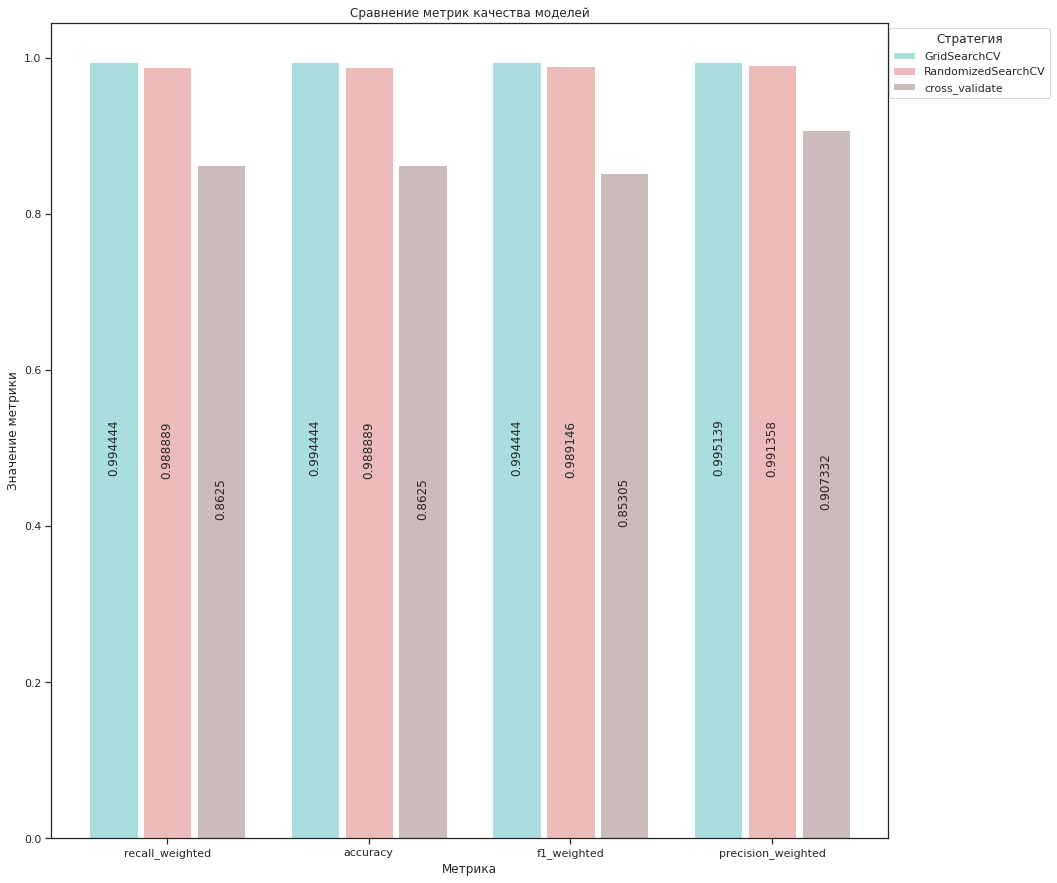

In [229]:
show_metrics_grouped_bar_chart(metrics_data)